# Introduction to Machine Learning Course: Facies Data Preparation and Classification

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Facies/Facies_Classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this notebook, the focus will be in the data preparation prior to modeling.

# Summary

* Data preparation
    * Cleaning
    * Imputation (with neural networks)
    * Feature engineering
* Classification
    * Gradient boosting classifier

# Data Preparation

First let's load some useful packages

For the well log data analyses, the main packages used are:
* Pandas
* Matplotlib
* Seaborn

Also, from the file `utils.py`, load the log visualization function.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import numpy as np
from utils import make_facies_log_plot
from plots import make_facies_log_plot_reg
from sklearn.metrics import confusion_matrix
import itertools
from pandas_profiling import ProfileReport

mpl.rcParams['figure.figsize'] = (8.0, 8.0)
inline_rc = dict(mpl.rcParams)
plt.style.use("seaborn")

In [2]:
#import pip
#!pip install -U pandas_profiling

In [3]:
# If seaborn package is missing, uncomment and run the following line:
# ! pip install seaborn

This data is from the [2016 ML contest](https://github.com/seg/2016-ml-contest), with the focus for *Facies Classification*.

The provided data is a CSV file with well logs information from different wells. There are 5 well logs and 2 indicators:

* Gamma ray (GR)
* Resistivity (ILD\_log10)
* Photoelectric effect (PE)
* Neutron-density porosity difference (DeltaPHI)
* Average neutron-density porosity (PHIND)
* Nonmarine/marine indicator (NM\_M)
* Relative position (RELPOS)

The goal is to train a model able to classify 9 different types of rocks, as listed in the following table:

| Facies | Description | Label | Adjacent Facies|
| :---:  |    :---:    | :---: |      :---:     |
|   1    | Nonmarine Sandstone | SS | 2 |
|   2    | Nonmarine coarse siltstone | CSiS | 1,3 |
|   3    | Nonmarine fine siltstone | FSiS | 2 |
|   4    | Marine siltstone and shale | SiSh | 5 |
|   5    | Mudstone | MS | 4,6 |
|   6    | Wackestone | WS | 5,7,8 |
|   7    | Dolomite | D | 6,8 |
|   8    | Packstone-grainstone | PS | 6,7,9 |
|   9    | Phylloid-algal bafflestone | BS | 7,8 |

So, let's take a look at the data!

Loading the CSV file to *pandas* dataframe and cheking some of the features:

In [4]:
data = pd.read_csv('facies_vectors.csv')
data.head(5)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [5]:
print(sorted(data['Well Name'].unique()))

['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', 'LUKE G U', 'NEWBY', 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']


In [6]:
print(sorted(data['Facies'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
print(sorted(data['Formation'].unique()))

['A1 LM', 'A1 SH', 'B1 LM', 'B1 SH', 'B2 LM', 'B2 SH', 'B3 LM', 'B3 SH', 'B4 LM', 'B4 SH', 'B5 LM', 'B5 SH', 'C LM', 'C SH']


In [8]:
#ProfileReport(data)

## Features treatment

Before plotting the data, let's create the list of features names, colors, and check for missing data.

In [9]:
features = list(data)[4:]
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
target = 'Facies'
print(features)

['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']


Let's check for missing data in all the data frame columns:

In [10]:
print(data.isna().sum())

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64


## Missing values treatment - Median fill

Initially, the missing values will be filled simply by the median of the feature.

In [11]:
data = data.fillna(data.median())
print(data.isna().sum())

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64


## Plotting the logs

Let's use our function *make_facies_log_plot* to visualize the data.

<Figure size 216x288 with 0 Axes>

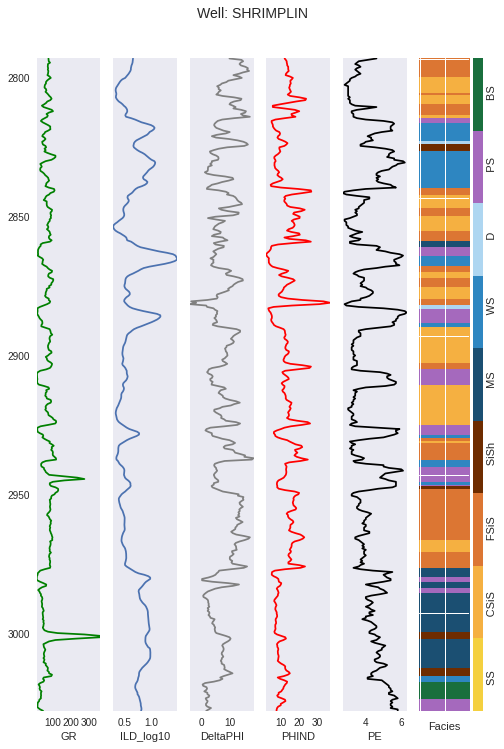

<Figure size 216x288 with 0 Axes>

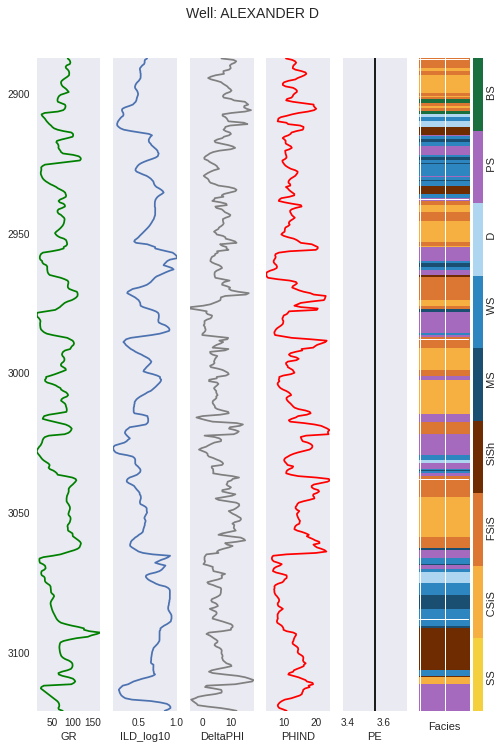

<Figure size 216x288 with 0 Axes>

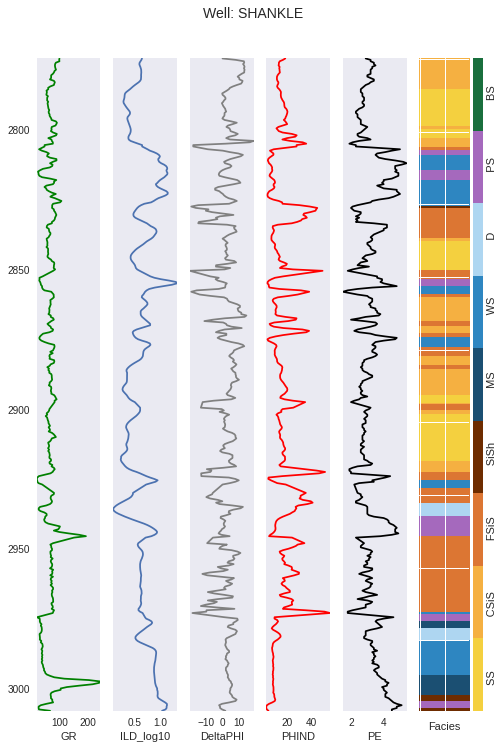

<Figure size 216x288 with 0 Axes>

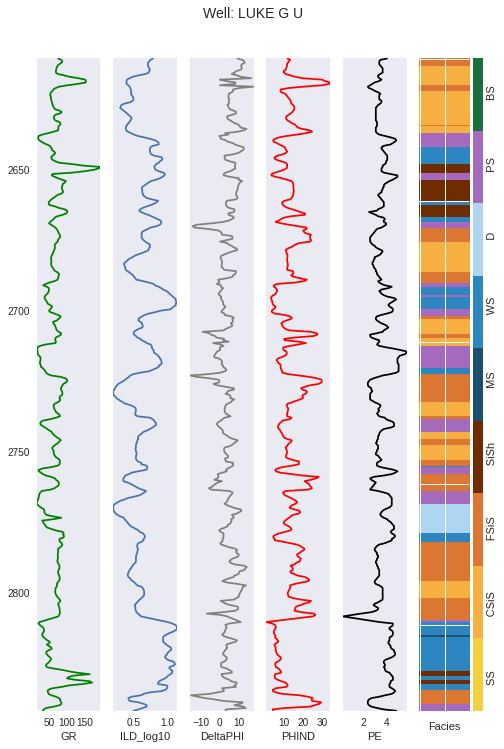

<Figure size 216x288 with 0 Axes>

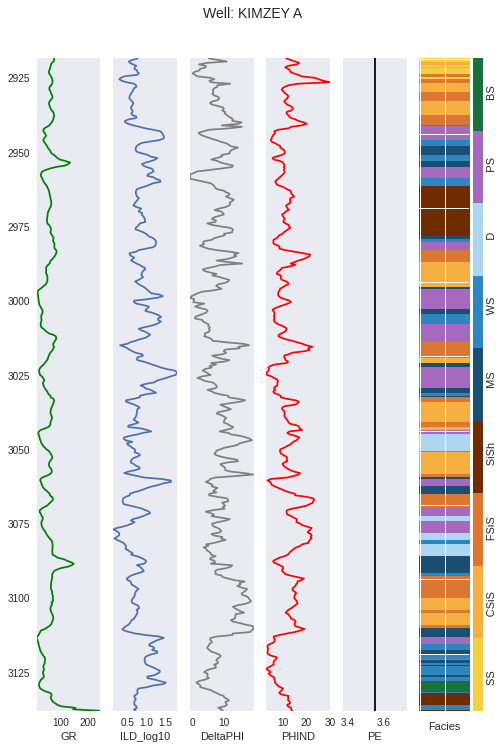

<Figure size 216x288 with 0 Axes>

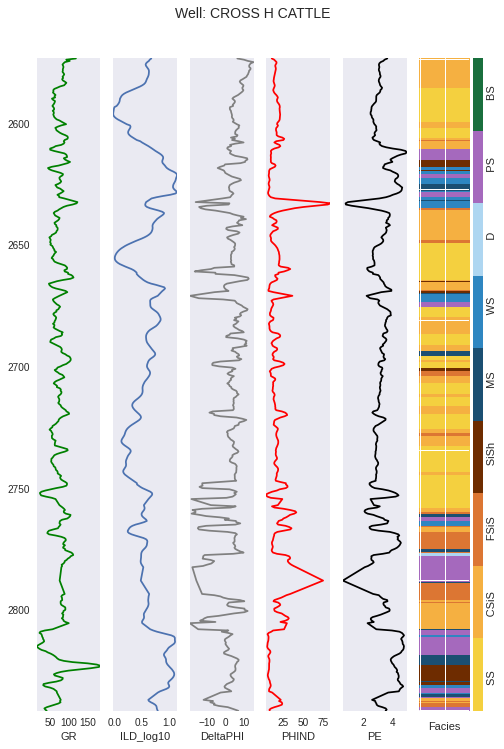

<Figure size 216x288 with 0 Axes>

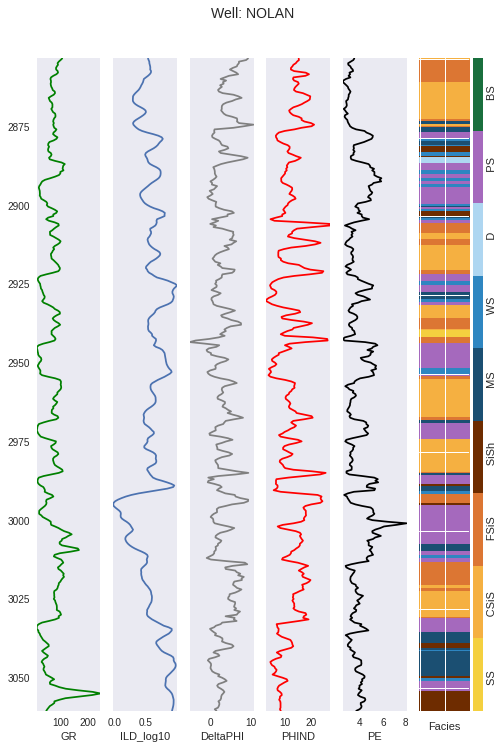

<Figure size 216x288 with 0 Axes>

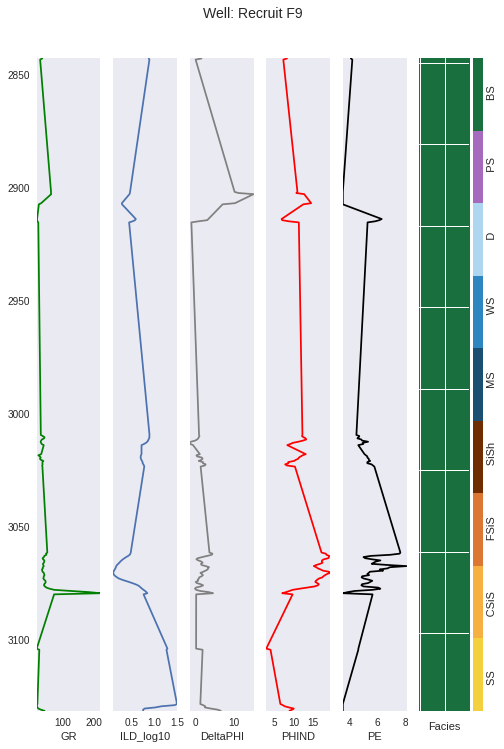

<Figure size 216x288 with 0 Axes>

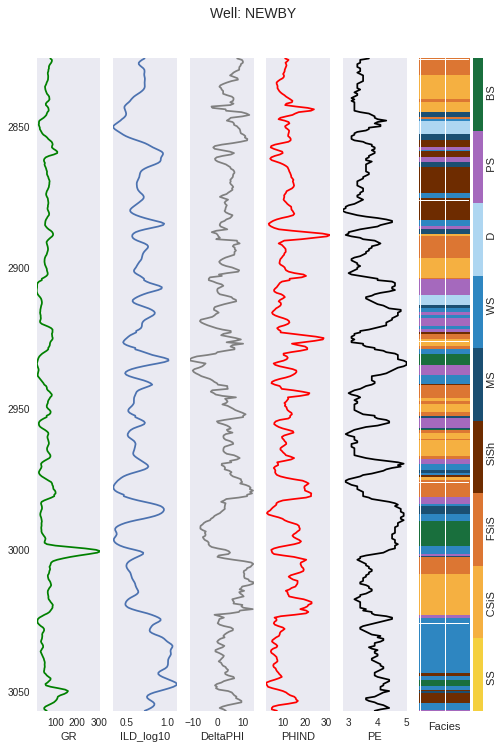

<Figure size 216x288 with 0 Axes>

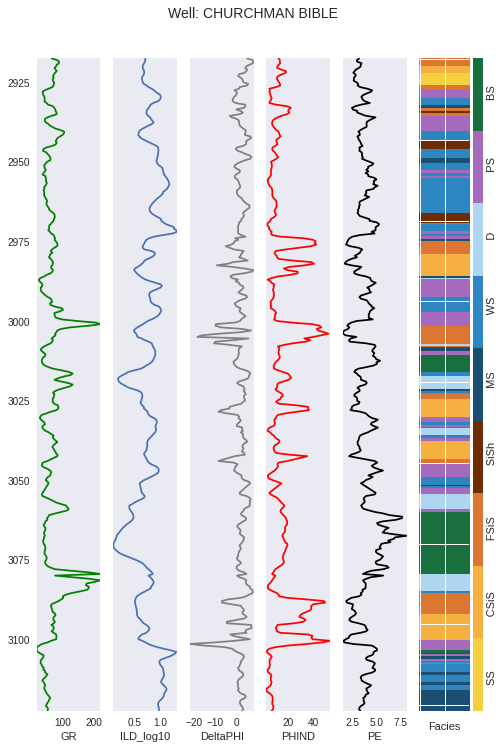

In [12]:
for wellName in data['Well Name'].unique():
    plt.figure(figsize=(3,4))
    make_facies_log_plot(data[data['Well Name'] == wellName], facies_colors = facies_colors)

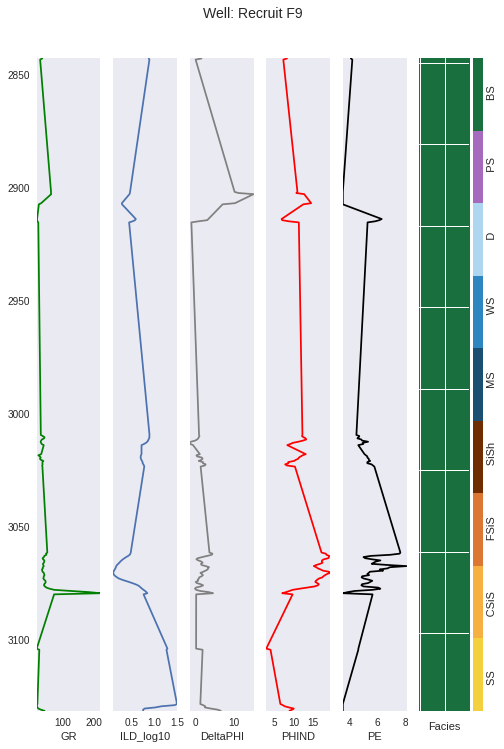

In [13]:
make_facies_log_plot(data[data['Well Name'] == 'Recruit F9'], facies_colors = facies_colors)

## Removing "broken" well (data cleaning)

The well *Recruit F9* is, apparently, not so... well!!

Remove it from the data:

In [14]:
data = data[data['Well Name'] != 'Recruit F9']
print(data['Well Name'].unique())

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A'
 'CROSS H CATTLE' 'NOLAN' 'NEWBY' 'CHURCHMAN BIBLE']


## Missing values treatment - is median fill good enough?

Missing data for *PE* are full in 2 wells:

+ Alexander D
+ Kimzey A

Is a median fill a good strategy to complete the missing data?

Let's check the wells.

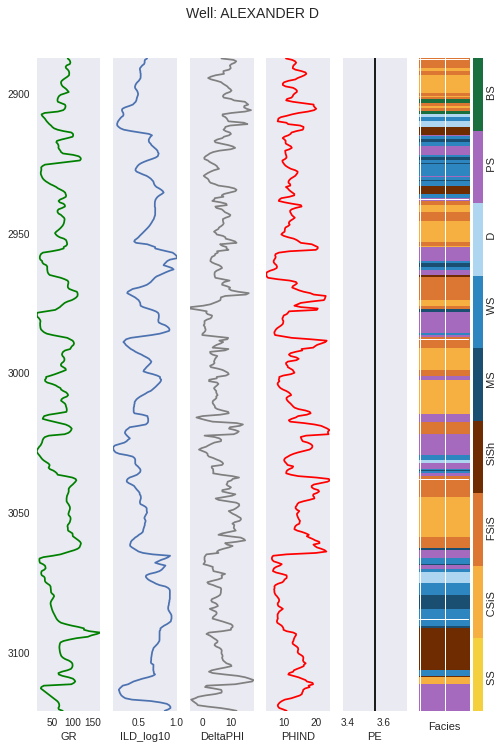

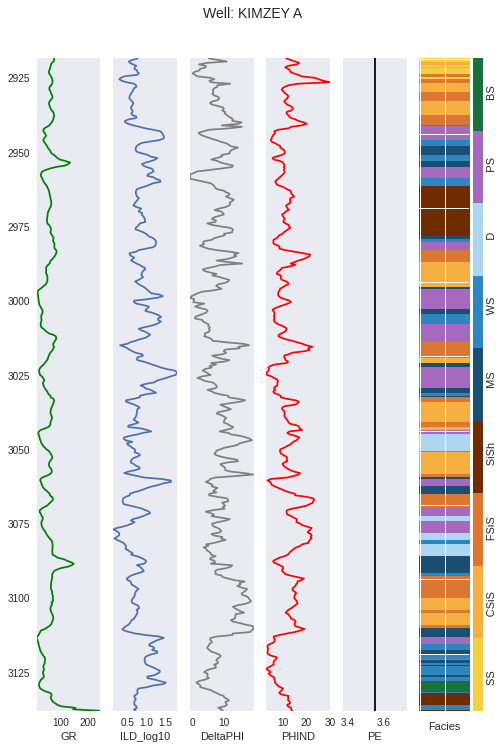

In [15]:
make_facies_log_plot(data[data['Well Name'] == 'ALEXANDER D'], facies_colors = facies_colors)
make_facies_log_plot(data[data['Well Name'] == 'KIMZEY A'], facies_colors = facies_colors)

# Data Imputation

The *photoelectric effect* (PE) completely missing for two wells. Filling it with the median of all PE values is not an optimized solution, and can lead to a biased model.

A more suitable solution would be to train a regression model using the other logs as input and the PE as target.

<img src="https://github.com/dtrad/geoml_course/blob/master/Facies/figures/imputation.png?raw=1" width="1000" align="center">

Separate the wells *Alexander D* and *Kimzey A*, and choose another well for validation:

In [16]:
well_val = ['SHANKLE'] # Choose your validation well
wells = data['Well Name'].unique()
wells_missing = ['ALEXANDER D', 'KIMZEY A']

wells_regression = wells[wells != wells_missing[0]]
wells_regression = wells_regression[wells_regression != wells_missing[1]]
wells_regression = wells_regression[wells_regression != well_val]

wells_regression

array(['SHRIMPLIN', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [17]:
data_val_reg = data[data['Well Name'].isin(well_val)]
data_reg = data[data['Well Name'].isin(wells_regression)]
data_reg['Well Name'].unique()

array(['SHRIMPLIN', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [18]:
features_reg = features[0:4]
print(features_reg)

['GR', 'ILD_log10', 'DeltaPHI', 'PHIND']


In [19]:
target_reg = ['PE']

## Metrics

Mean squared error:

$$ MSE(\bar{y},y) = \frac{1}{n_{samples}} \sum_{i = 0}^{n_{samples} -1}(y_i - \bar{y}_i)^2 $$

Explained variance score:

$$ EV(\bar{y},y) = 1 - \frac{Var\{y - \bar{y}\}}{Var\{y\}} $$

[Scikit-Learn documentation for Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

[Scikit-Learn documentation for Explained Variance Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score)

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

## Neural Networks

Artificial Neural Networks (ANN), or simply Neural Networks (NN), is an algorithm inspired by the biological neural networks.

<img src="https://github.com/dtrad/geoml_course/blob/master/Facies/figures/NN.jpeg?raw=1" class="center">

[Source](https://medium.com/datadriveninvestor/when-not-to-use-neural-networks-89fb50622429)

A neural networks model is contains three types of layers:
* Input layer: the input features.
* Hidden layer(s): a series of one or more layers, containing the neurons (or perceptron), that are fully connected between the layers. Inside each neuron there is an activation function, to add non-linear properties to the model. The most common one is the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).
* Output layer: one or more vectors of predictions (regressors, probabilities, or classes).

It is called **Deep Learning** any neural netwoks model that contain two or more hidden layers.

Here, we are going to use a neural networks model for regression.

[Scikit-Learn documentation for Regression Neural Network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

In [21]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(10,10,10,10,10),  
                        activation = 'relu', 
                        solver = 'lbfgs', 
                        alpha = 0.01, 
                        batch_size = 'auto',
                        learning_rate = 'constant',
                        learning_rate_init = 0.01,
                        power_t = 0.3,
                        max_iter = 1000,
                        shuffle = True,
                        random_state = 10,
                        tol = 0.0001,
                        verbose = False,
                        warm_start = False,
                        momentum = 0.9,
                        nesterovs_momentum = True,
                        early_stopping = True,
                        validation_fraction = 0.2,
                        beta_1 = 0.9,
                        beta_2 = 0.999,
                        epsilon = 1e-08)

model.fit(data_reg[features_reg], data_reg[target_reg])

pred = model.predict(data_val_reg[features_reg])

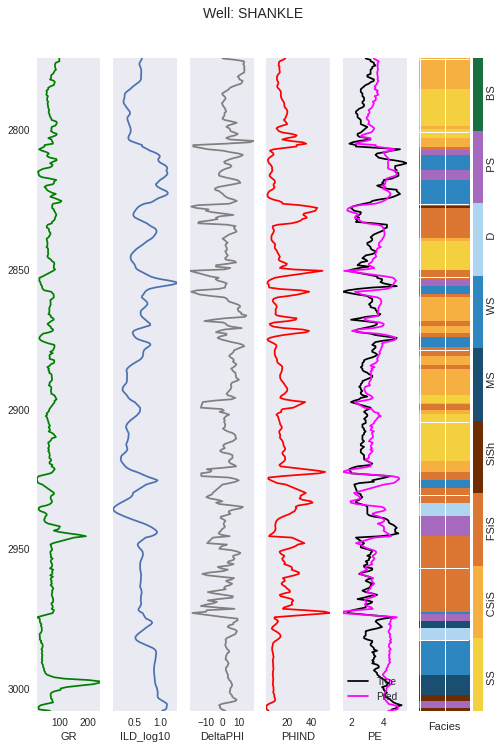

In [22]:
make_facies_log_plot_reg(data_val_reg, pred, facies_colors = facies_colors)

In [23]:
print('Mean squared error: ',mean_squared_error(data_val_reg.PE, pred))
print('')
print('Explained Variance Score: ', explained_variance_score(data_val_reg.PE, pred))

Mean squared error:  0.3473394165775462

Explained Variance Score:  0.5769035660764025


## Replacing PE values with regression predictions

Chose your model of prederence:

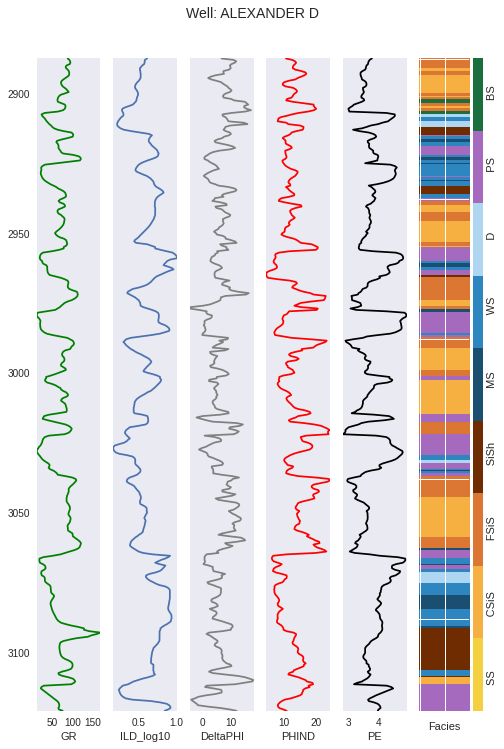

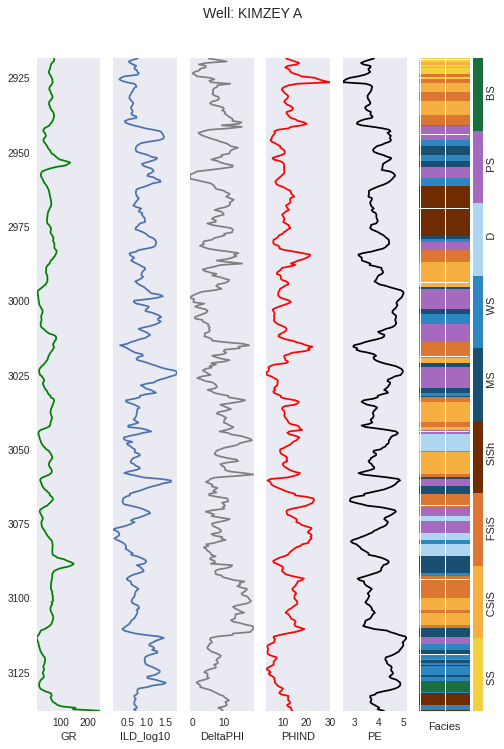

In [24]:
data.PE[data[data['Well Name'] == wells_missing[0]].PE.index] = model.predict(data.loc[data[data['Well Name'] == wells_missing[0]].index,features_reg])
make_facies_log_plot(data[data['Well Name'] == wells_missing[0]], facies_colors = facies_colors)

data.PE[data[data['Well Name'] == wells_missing[1]].PE.index] = model.predict(data.loc[data[data['Well Name'] == wells_missing[1]].index,features_reg])
make_facies_log_plot(data[data['Well Name'] == wells_missing[1]], facies_colors = facies_colors)

Saving the new CSV file with the processed wells:

In [25]:
data.to_csv('Processed_Wells.csv', index=False)

# Data Analysis and Modeling

In [26]:
well_names = sorted(data['Well Name'].unique())
for i in well_names:
    print(i, sorted(data[data['Well Name'] == i].Facies.unique()))

ALEXANDER D [2, 3, 4, 5, 6, 7, 8, 9]
CHURCHMAN BIBLE [1, 2, 3, 4, 5, 6, 7, 8, 9]
CROSS H CATTLE [1, 2, 3, 4, 5, 6, 7, 8]
KIMZEY A [1, 2, 3, 4, 5, 6, 7, 8, 9]
LUKE G U [2, 3, 4, 5, 6, 7, 8]
NEWBY [2, 3, 4, 5, 6, 7, 8, 9]
NOLAN [1, 2, 3, 4, 5, 6, 7, 8]
SHANKLE [1, 2, 3, 4, 5, 6, 7, 8]
SHRIMPLIN [2, 3, 4, 5, 6, 7, 8, 9]


As during the regression block, define the features, target, facies colors, and facies names.

In [27]:
features = list(data)[4:]
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_names_dict = {0 : 'SS', 1 : 'CSiS', 2 : 'FSiS', 3 : 'SiSh', 4 : 'MS', 5 : 'WS', 6 : 'D', 7 : 'PS', 8 : 'BS'}
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
target = 'Facies'
print(features)

['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']


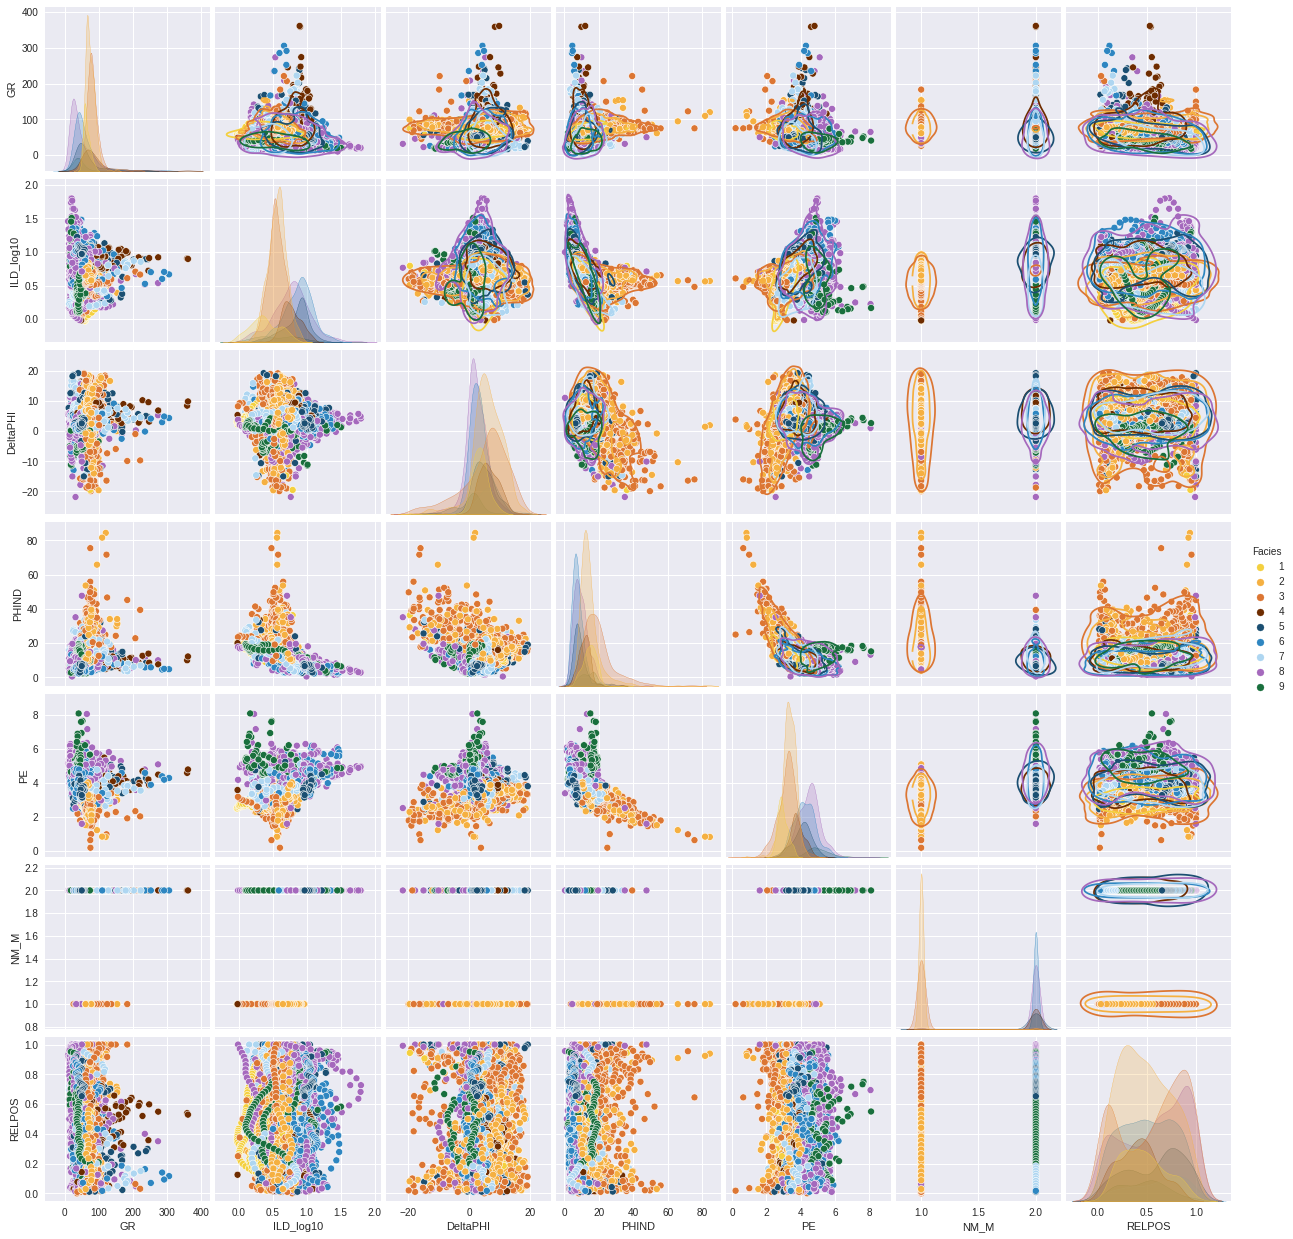

In [28]:
g = sns.pairplot(data[features + [target]], 
                 hue = 'Facies', 
                 palette = facies_colors)

g.map_upper(sns.kdeplot, levels = 1, color = ".2")

## Feature augmentation

From the pairs plot, some of the logs combination showed a circular pattern over the facies classification. Machine learning classifier models like to use linear classification boundaries between the classes. An approximate circular boundary would require a very complex model, and a large dataset to be trained.

One way to avoid it is by *feature engineering*, where the original features are used to create new features that may help the predictions. Here, from the circular pattern observation, convert the features to an equivalent in polar coordinates sounds as a smart solution:

<img src="https://github.com/dtrad/geoml_course/blob/master/Facies/figures/polcor.png?raw=1" width="800">

Having two features $X_1$ and $X_2$, the radius $r$ and angle $\phi$ are computed by the following equations:

$$r = \sqrt{{X_1}^2 + {X_2}^2}$$
$$\phi = \arctan\left(\frac{X_2}{X_1}\right)$$

In [29]:
# Transforming the pair plots into polar coordinates
def card2polwells(data_in, features_wells):
    data_polar = data_in
    fea_red = features_wells
    name_temp = features_wells
    for fea1 in features_wells:
        del fea_red[0]
        for fea2 in fea_red:
            x = data_in[fea1]/max(data_in[fea1])
            y = data_in[fea2]/max(data_in[fea2])
            data_polar[fea1 + '_' + fea2 + '_rho'] = np.sqrt(x**2 + y**2)
            data_polar[fea1 + '_' + fea2 + '_phi'] = np.arctan2(y, x)
    
    return(data_polar)

In [30]:
features_in = ['GR','ILD_log10','DeltaPHI','PHIND','PE']
data_polar = card2polwells(data, features_in)
data_polar.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,DeltaPHI_DeltaPHI_rho,DeltaPHI_DeltaPHI_phi,DeltaPHI_PHIND_rho,DeltaPHI_PHIND_phi,DeltaPHI_PE_rho,DeltaPHI_PE_phi,PE_PHIND_rho,PE_PHIND_phi,PE_PE_rho,PE_PE_phi
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,...,0.724975,0.785398,0.531718,0.268726,0.765366,0.836870,0.585594,0.243475,0.803729,0.785398
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,...,1.039863,0.785398,0.750214,0.199769,0.892888,0.603241,0.527972,0.285851,0.716367,0.785398
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,...,1.083801,0.785398,0.781805,0.199087,0.886079,0.525860,0.470884,0.334570,0.629005,0.785398
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,...,1.017894,0.785398,0.736343,0.212629,0.839667,0.540995,0.459492,0.344982,0.611533,0.785398
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,...,0.988602,0.785398,0.716589,0.221719,0.815550,0.541088,0.448649,0.358893,0.594061,0.785398


Other augmentations can be done, such as the gradient of the features, the square of the features, etc. But we will only do the polar coordinates transform for now.

Let's go for the facies classification.

## Separating well for validation

Select one of the wells to be used as validation. The options are:

In [31]:
print(data_polar['Well Name'].unique())

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A'
 'CROSS H CATTLE' 'NOLAN' 'NEWBY' 'CHURCHMAN BIBLE']


In [32]:
val_well = 'SHANKLE'   # type the name of the validation well
data_train = data_polar[data_polar['Well Name'] != val_well]
data_val = data_polar[data_polar['Well Name'] == val_well]
print(data_train['Well Name'].unique())
print(data_val['Well Name'].unique())

['SHRIMPLIN' 'ALEXANDER D' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'NEWBY' 'CHURCHMAN BIBLE']
['SHANKLE']


In [33]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize = False):

    if normalize:
        row_sum = confusion_matrix.sum(axis = 1)
        confusion_matrix = confusion_matrix.astype('float') / row_sum[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'
    df_cm = pd.DataFrame(confusion_matrix)
    df_cm = df_cm.rename(index = class_names, columns = class_names)
    fig = plt.figure(figsize = figsize)
    plt.title(title)
    try:
        heatmap = sns.heatmap(df_cm, annot = True, cmap = 'Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [34]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(compadre,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('Predictions')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[6].set_yticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

## Accuracy score

In [35]:
from sklearn.metrics import accuracy_score

## Gradient Boosting

Scikit-learn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) for *Gradient Boosting*.

In [36]:
new_features = list(data_train)[4:]

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
model_GB = GradientBoostingClassifier(loss = 'deviance',
                                      learning_rate = 0.04, #
                                      n_estimators = 100,   #
                                      subsample = 1,
                                      criterion = 'friedman_mse',
                                      min_samples_split = 2,
                                      min_samples_leaf = 1,
                                      min_weight_fraction_leaf = 0.15,
                                      max_depth = 5,        #
                                      #min_impurity_decrease = 0.0,
                                      #min_impurity_split = None,
                                      init = None,
                                      random_state = 1,
                                      max_features = 'auto',
                                      verbose = 0,
                                      max_leaf_nodes = None,
                                      warm_start = False).fit(data_train[new_features], data_train[target])

pred_GB = model_GB.predict(data_val[new_features])
cm_GB = confusion_matrix(data_val[target], pred_GB)

print('Accuracy score')
print('Gradient Boosting: ', accuracy_score(data_val[target], pred_GB))

Accuracy score
Gradient Boosting:  0.5567928730512249


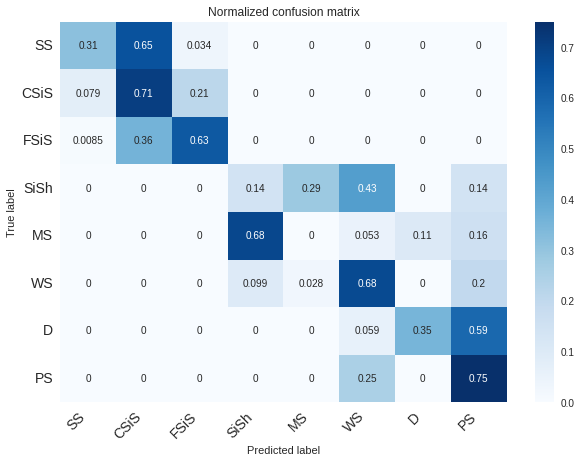

In [39]:
# Plot normalized confusion matrix
fig = print_confusion_matrix(cm_GB, class_names = facies_names_dict, normalize = True)
plt.show(fig)

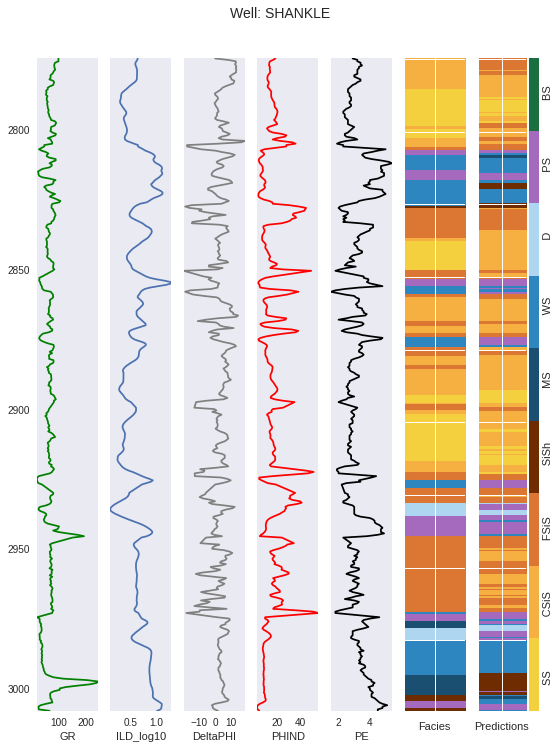

In [40]:
compare_facies_plot(logs = data_val, compadre = pred_GB, facies_colors = facies_colors)

<AxesSubplot:>

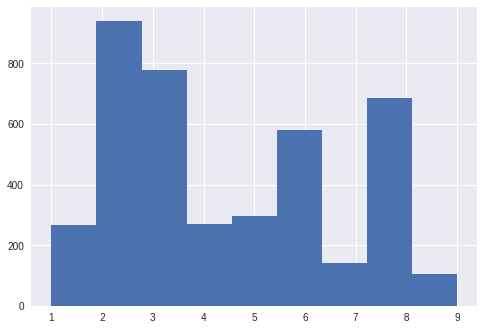

In [41]:
data['Facies'].hist(bins=9)

In [42]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy score')
print('Gradient Boosting: ', balanced_accuracy_score(data_val[target], pred_GB))

Balanced accuracy score
Gradient Boosting:  0.4471006499933615


In [43]:
#!pip install -U scikit-learn

In [44]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression(class_weight="balanced").fit(data_train[new_features], data_train[target])

In [45]:
pred_LR = model_LR.predict(data_val[new_features])

print("Accuracy: ", accuracy_score(data_val[target], pred_LR))
print("Balanced accuracy: ", balanced_accuracy_score(data_val[target], pred_LR))

Accuracy:  0.45434298440979953
Balanced accuracy:  0.4380182078740351


In [46]:
#!pip install xgboost

In [47]:
from xgboost import XGBClassifier, plot_importance

model = XGBClassifier(
    n_estimators = 100,
    max_depth = 5, 
    learning_rate = 0.04,
    objective = "multi:softmax",
    verbosity = 0
).fit(data_train[new_features], data_train[target])

pred = model.predict(data_val[new_features])

print("Accuracy: ", accuracy_score(data_val[target], pred))
print("Balanced accuracy: ", balanced_accuracy_score(data_val[target], pred))

Accuracy:  0.5100222717149221
Balanced accuracy:  0.5044032504425019


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

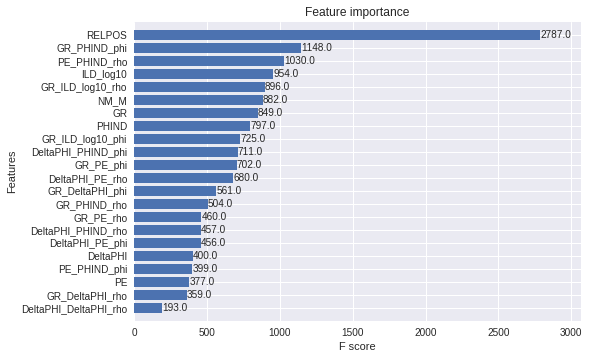

In [48]:
plot_importance(model, 
                height = 0.8)

$$\text{Thank you!}$$